In [1]:
from collections import defaultdict, OrderedDict
import math

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp, entropy

import sim_lib.util as util
import sim_lib.attr_lib.util as alu
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 16
iter_count = 10

params = {
    'context_count' : 2, # Needed for simple utility
    'k' : 1, # Needed for simple attribute utility
    'edge_selection' : alu.seq_projection_edge_edit,
    'seed_type' : 'grid', # Type of seed network
    'max_clique_size' : 5,
    'revelation_proposals' : alu.resistance_distance_revelation,
    'util_agg' : lambda a, s, c: a + s, # How to aggregate utility values
    'vtx_types' :
        {
            'type1' : { 'likelihood' : 0.5,
                      'struct_util' : None,
                      'init_attrs' : alu.init_cont_heterophily, # context 1
                      'edge_attr_util' : None,
                      'total_attr_util' : None,
                      'color' : 'blue' },
            'type0' : { 'likelihood' : 0.5,
                      'struct_util' : None,
                      'init_attrs' : alu.init_cont_homophily, # context 0
                      'edge_attr_util' : None,
                      'total_attr_util' : None,
                      'color' : 'red' }
        }
}

type1_count = math.floor(_N * params['vtx_types']['type1']['likelihood'])
vtx_types_list = ['type1'] * type1_count + ['type0'] * (_N - type1_count)
np.random.shuffle(vtx_types_list)
params['type_assignment'] = { i : vtx_types_list[i] for i in range(_N) }

assert sum([ t['likelihood'] for t in params['vtx_types'].values() ]) == 1.0

In [3]:
def get_struct_utils(G):
    return [ u.data['struct_util'](u, G) for u in G.vertices ]

def get_attribute_utils(G):
    return [ u.data['total_attr_util'](u, G) for u in G.vertices ]

def get_degrees(G):
    return [ u.degree for u in G.vertices ]

def get_costs(G):
    return [ alu.calc_cost(u, G) for u in G.vertices ]

In [4]:
def plot_grid_values(metrics):
    plt_idx = 1
    val_fig = plt.figure(figsize=(20, 20))
    comp_fig = plt.figure(figsize=(20, 20))
    
    metric_cnt = len(metrics)
    strategies_cnt = len(metrics[0][1].values())
    for metric, strat_values in metrics:
        for strategy, sm_values in strat_values.items():
            
            # Create subplots
            val_ax = val_fig.add_subplot(metric_cnt, strategies_cnt, plt_idx)
            comp_ax = comp_fig.add_subplot(metric_cnt, strategies_cnt, plt_idx)
            comp_ax2 = comp_ax.twinx()
            plt_idx += 1
            
            x_vals = list(range(iter_count))
            
            for seed, seed_values in sm_values.items():
                val_ax.plot(x_vals,
                            [ np.mean(seed_values[it]) for it in range(iter_count) ],
                            label=seed)
            val_ax.set_title(f'{strategy}; {metric}')
                
            ks_values = [ ks_2samp(sm_values['grid'][it], sm_values['trivial'][it])[0] \
                         for it in range(iter_count) ]
            kl_values = [ entropy(sm_values['trivial'][it], sm_values['grid'][it]) \
                         for it in range(iter_count) ] # entropy does normalization internally
            comp_ax.plot(x_vals, ks_values, color='orange', label='KS score')
            comp_ax2.plot(x_vals, kl_values, color='blue', label='KL score')
            comp_ax.set_title(f'{strategy}; {metric}')
                
    plt.xlabel('Iteration')
    plt.legend(loc='upper right')
    plt.show()

Theta value: 1.0


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning:

invalid value encountered in true_divide



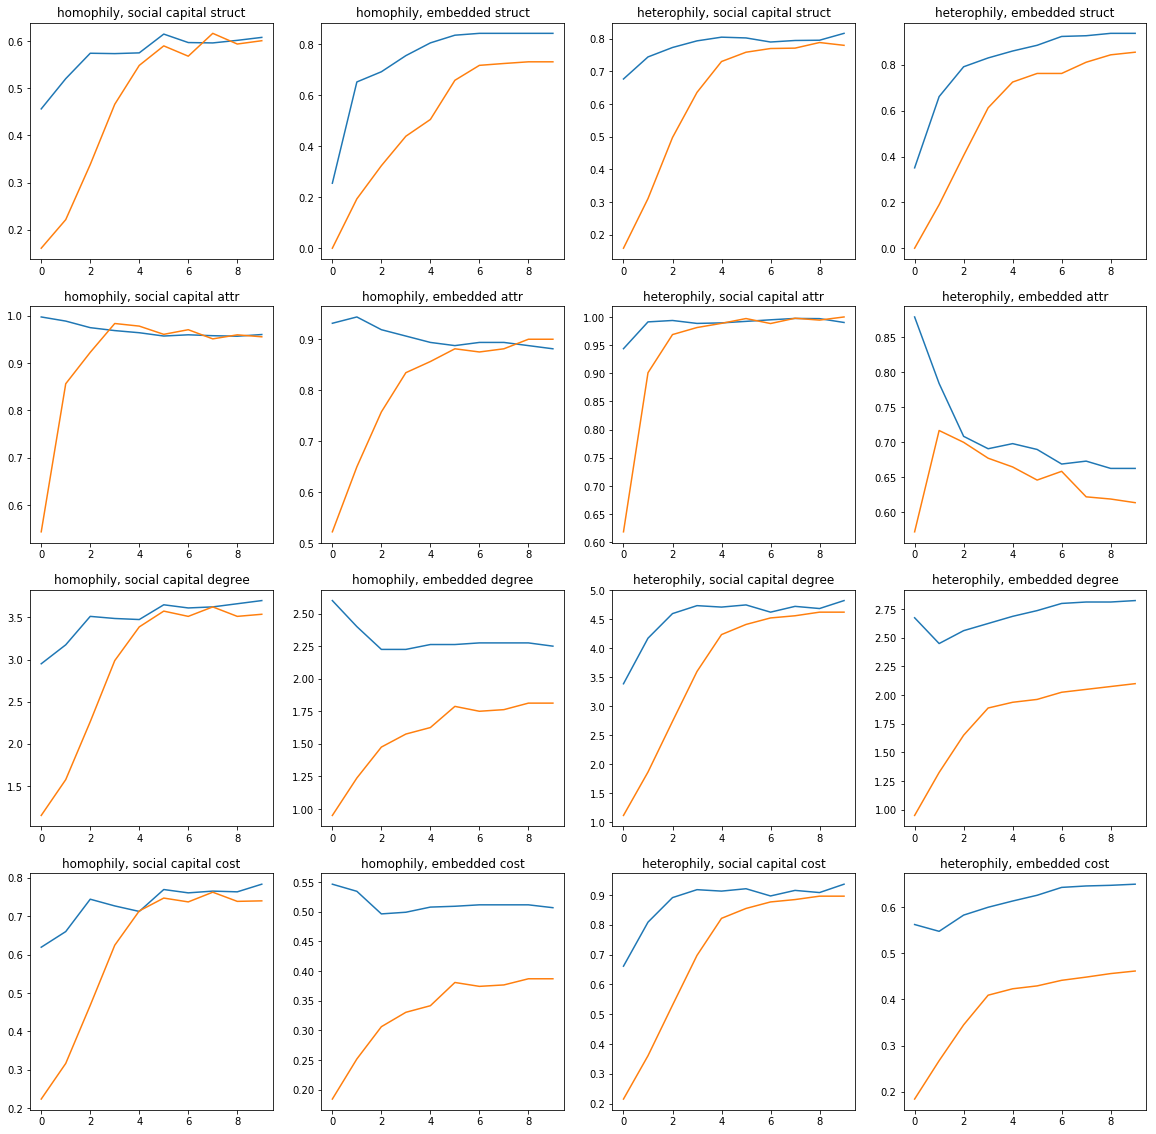

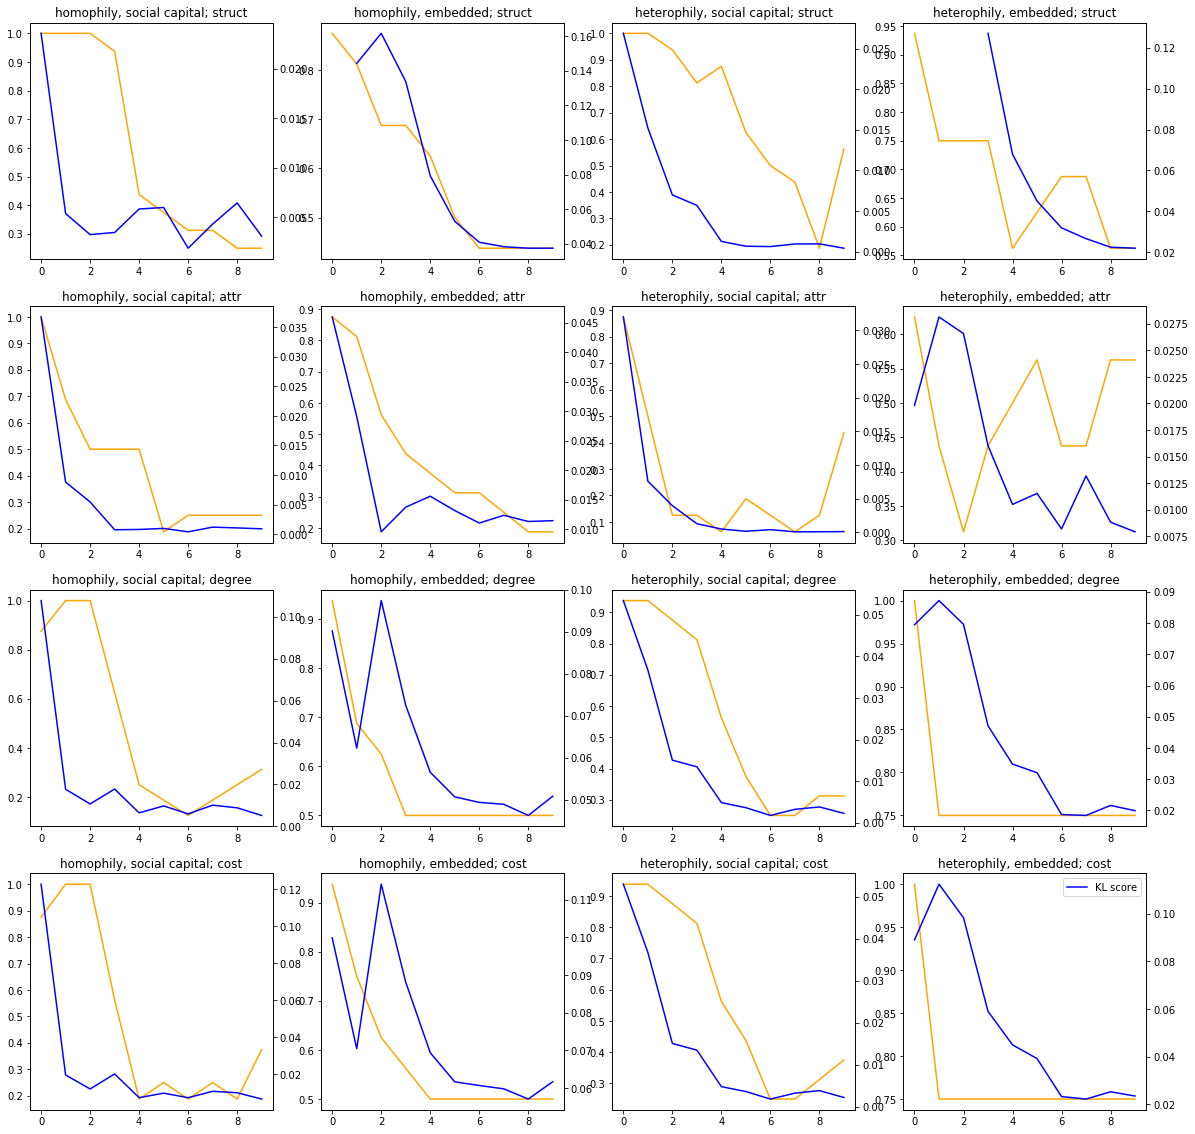

Theta value: 0.75


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning:

invalid value encountered in true_divide



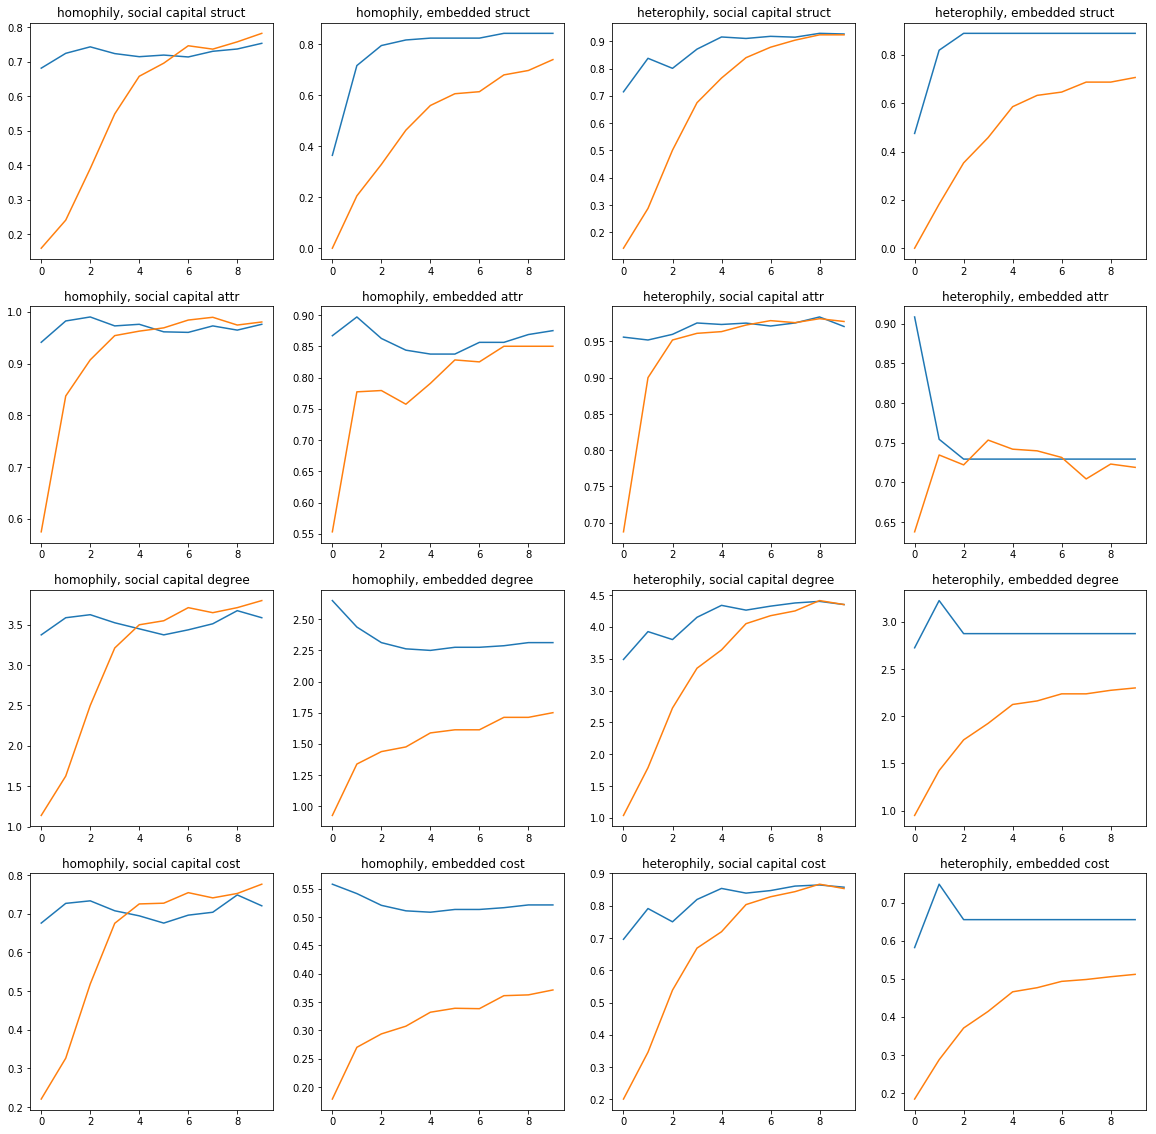

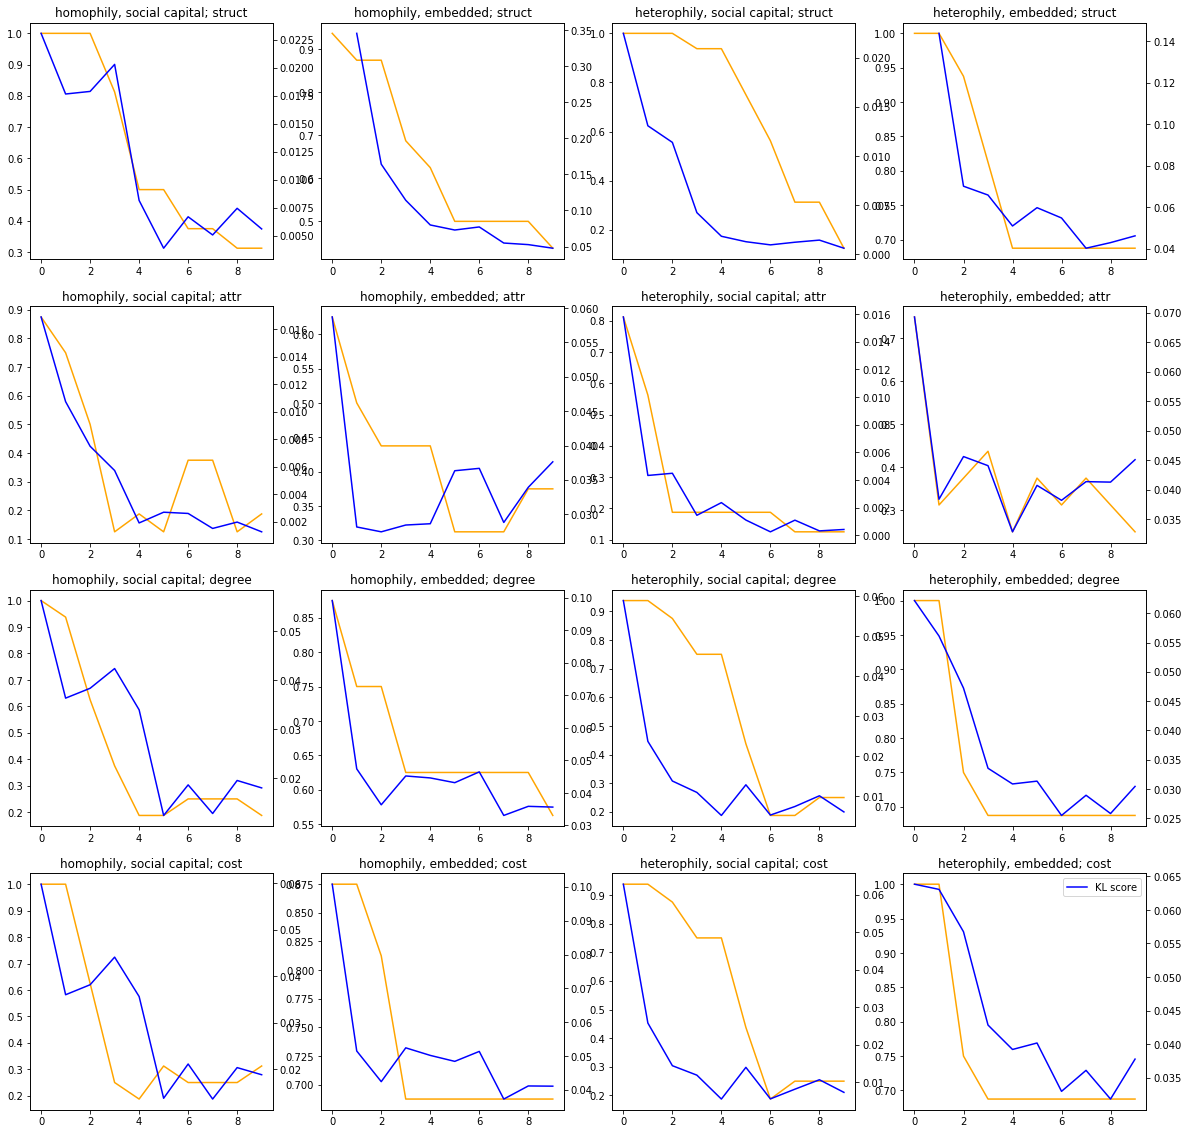

Theta value: 0.5


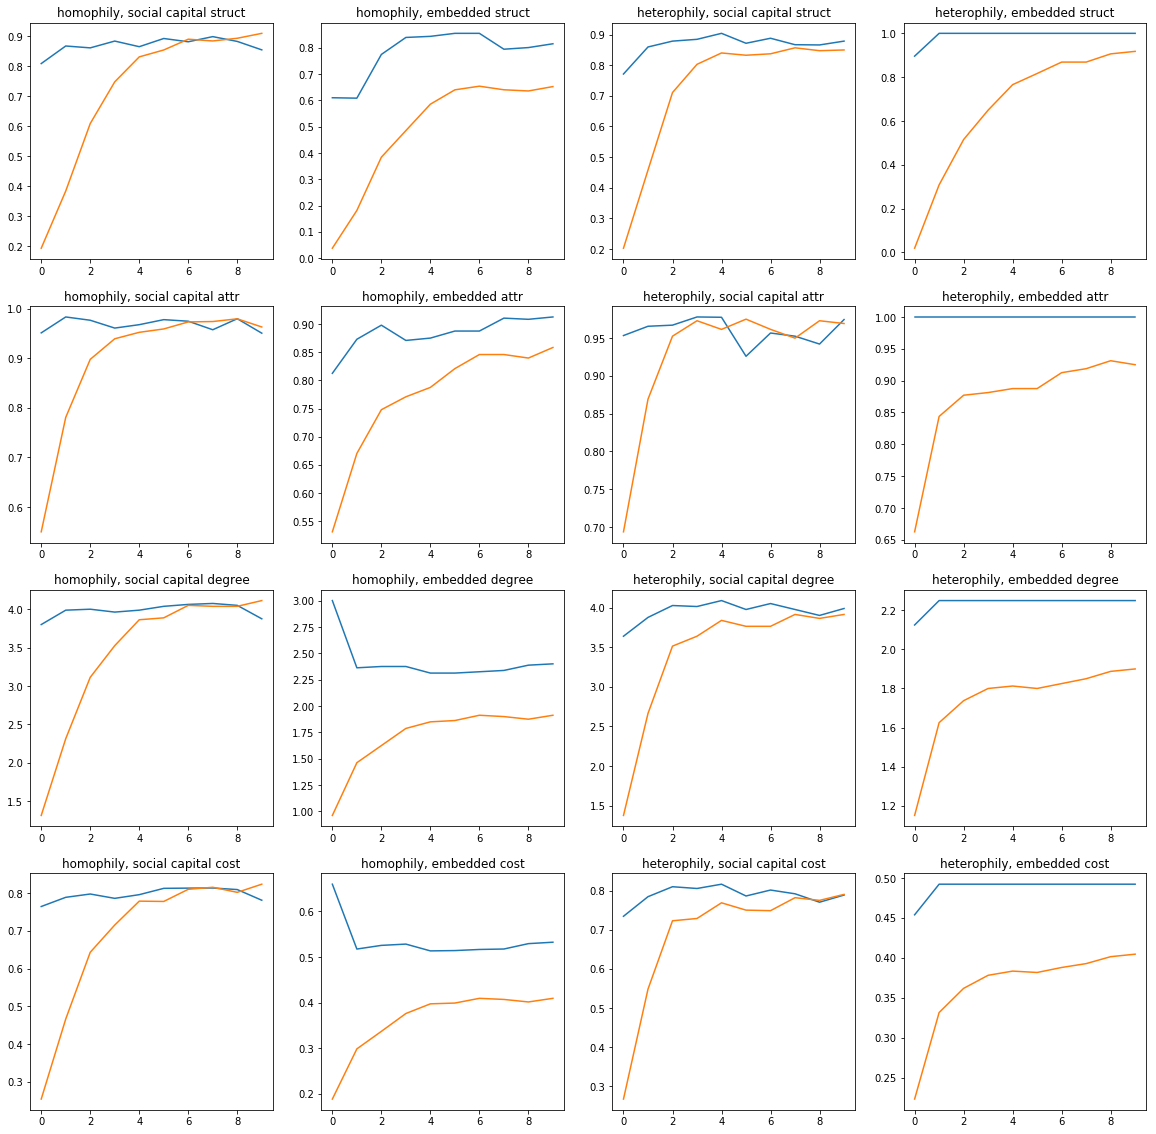

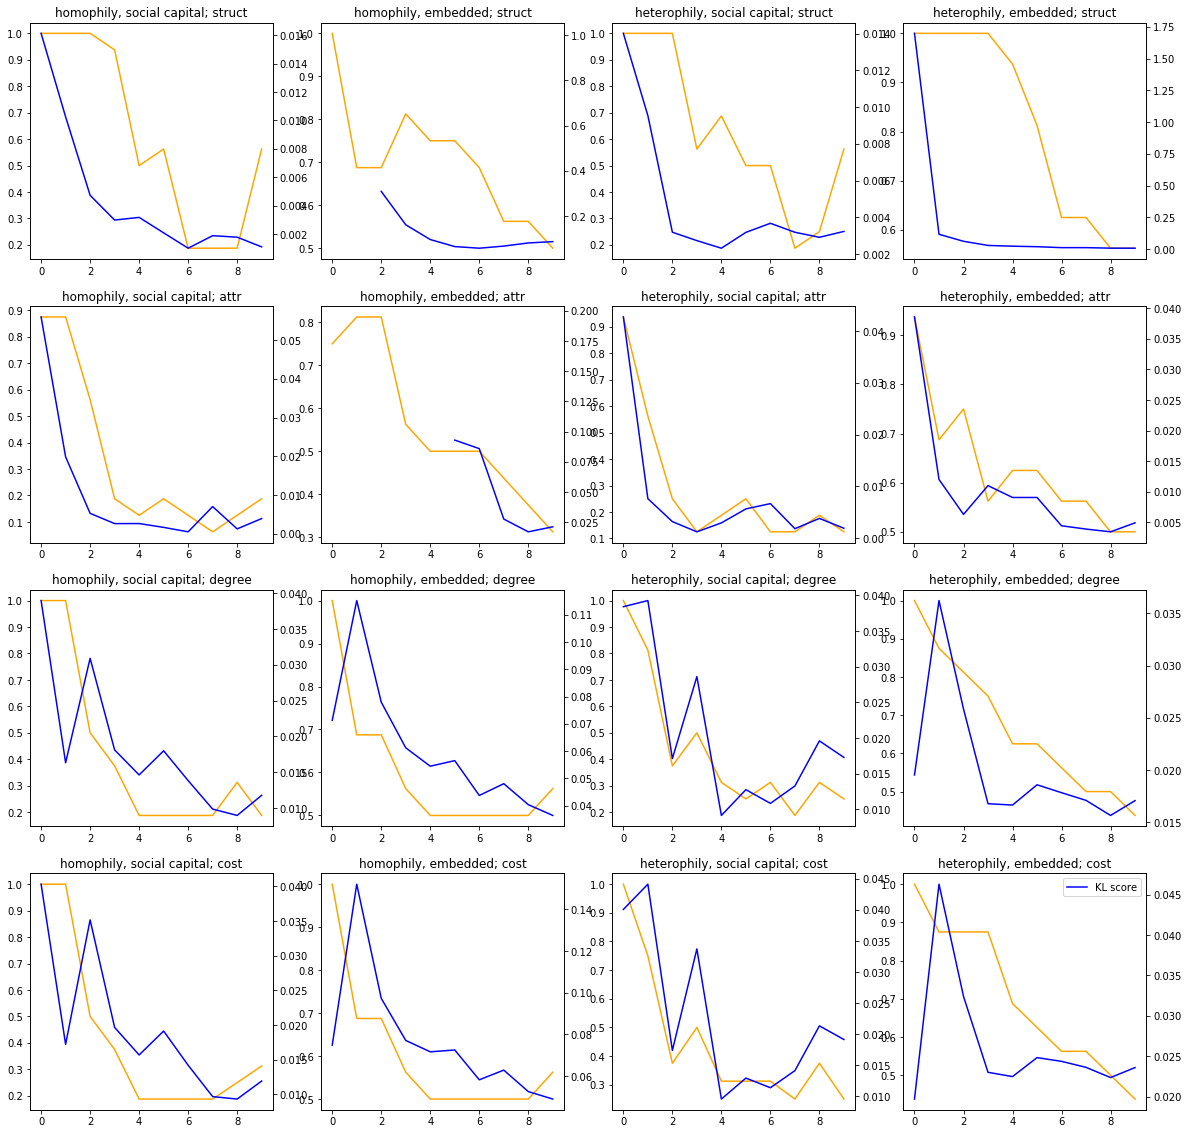

Theta value: 0.25


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning:

invalid value encountered in true_divide



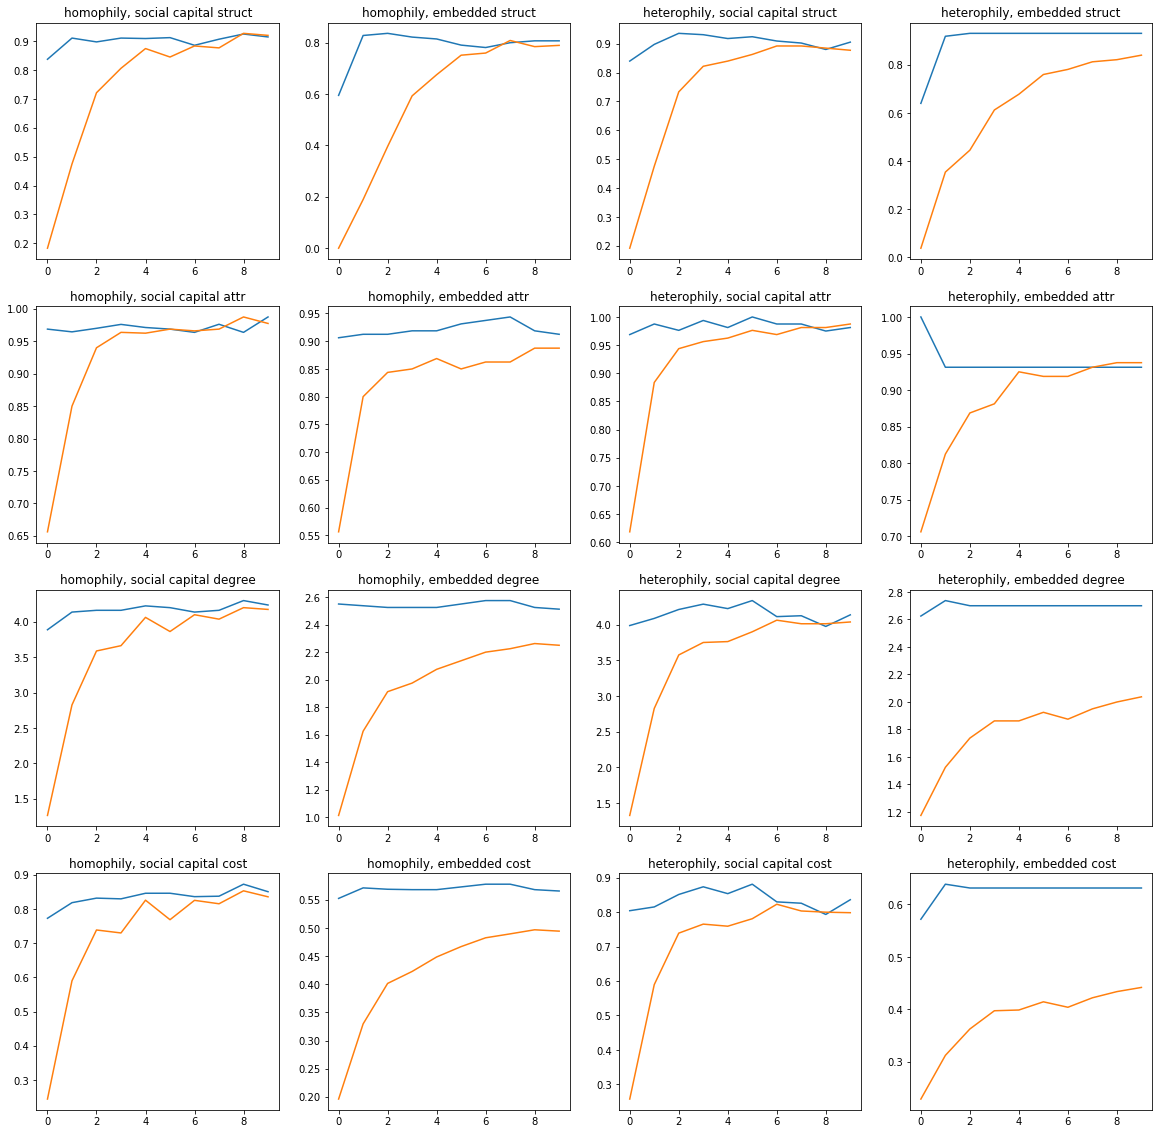

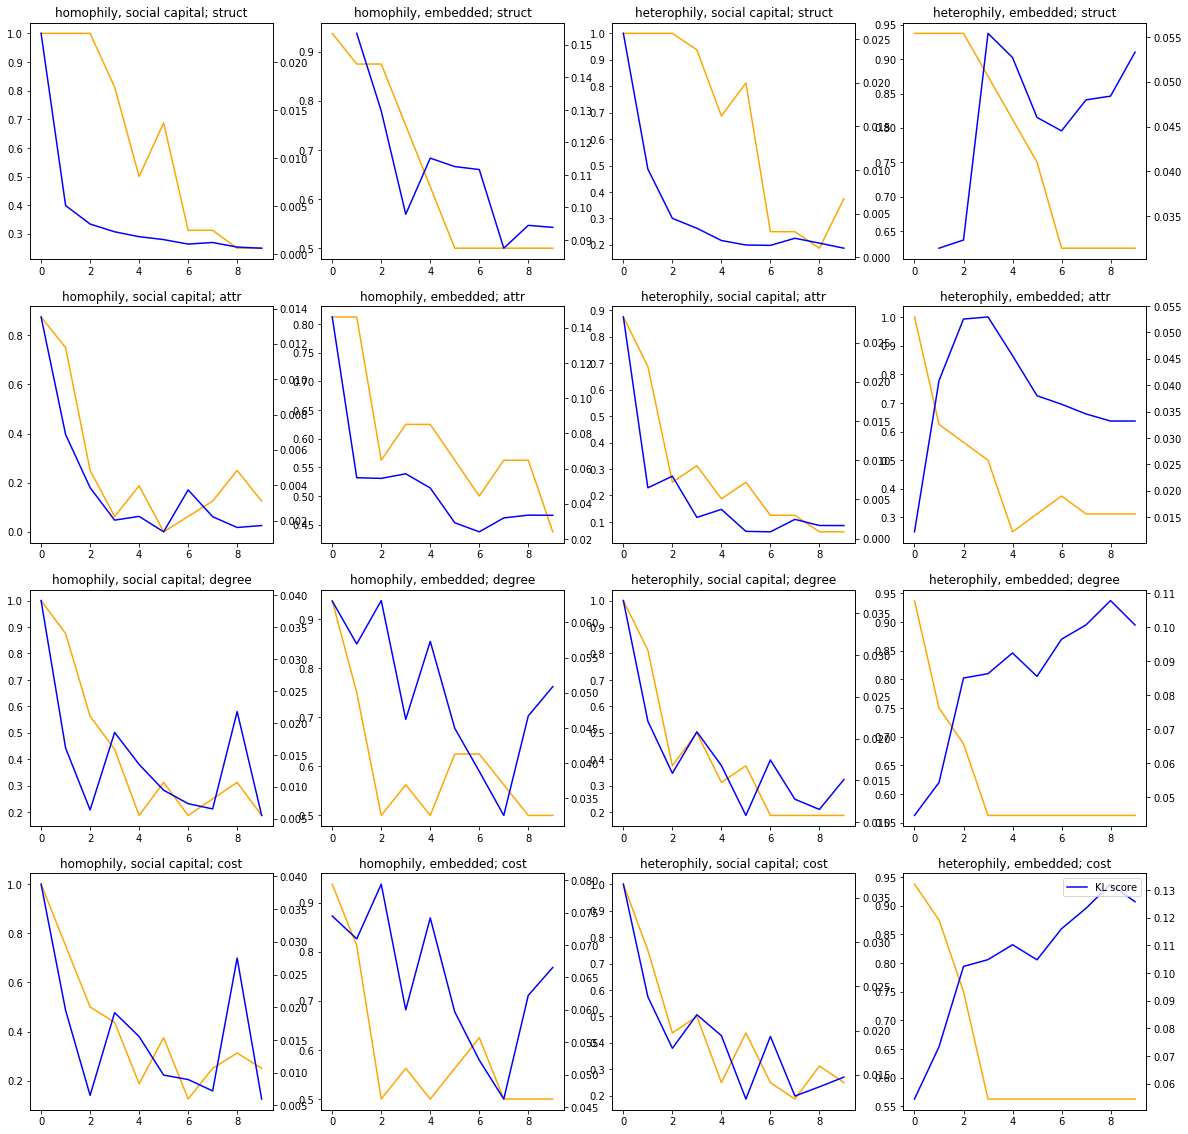

In [5]:
# Parameters
similarity_funcs = list(alu.gen_similarity_funcs())
attr_func_named = list(zip(similarity_funcs, ['homophily', 'heterophily']))
theta_values = [0.25, 0.5, 0.75, 1.0][::-1]
struct_funcs = [alu.ball2_size, alu.average_neighborhood_overlap]
struct_func_named = list(zip(struct_funcs, ['social capital', 'embedded']))
seed_types = ['grid', 'trivial']
num_runs = 10

for theta in theta_values:
    struct_utils = OrderedDict()
    attr_utils = OrderedDict()
    degrees = OrderedDict()
    costs = OrderedDict()
    for idx, (sim_func, af_name) in enumerate(attr_func_named):
        attr_func = alu.gen_schelling_seg_funcs(theta, 'satisfice')[idx]
        for struct_func, sf_name in struct_func_named:
            
            strat_str = f'{af_name}, {sf_name}'
            struct_utils[strat_str] = {}
            attr_utils[strat_str] = {}
            degrees[strat_str] = {}
            costs[strat_str] = {}
            
            for vtype in ['type0', 'type1']:
                params['vtx_types'][vtype]['struct_util'] = struct_func
                params['vtx_types'][vtype]['edge_attr_util'] = sim_func
                params['vtx_types'][vtype]['total_attr_util'] = attr_func
                
            # Run simulations
            for seed in seed_types:
                struct_utils[strat_str][seed] = defaultdict(list)
                attr_utils[strat_str][seed] = defaultdict(list)
                degrees[strat_str][seed] = defaultdict(list)
                costs[strat_str][seed] = defaultdict(list)

                params['seed_type'] = seed
                
                for _ in range(num_runs):
                    G = attribute_network(_N, params)
                    for it in range(iter_count):
                        
                        # Iterate simulation
                        calc_edges(G)
                        
                        # Record values
                        struct_utils[strat_str][seed][it].append(get_struct_utils(G))
                        attr_utils[strat_str][seed][it].append(get_attribute_utils(G))
                        degrees[strat_str][seed][it].append(get_degrees(G))
                        costs[strat_str][seed][it].append(get_costs(G))
                        
                # Get averages across different runs per iteration
                def avg_dict(d):
                    it_avg = lambda d, it : np.mean(np.array(d[seed][it]), axis=0)
                    averaged = [ it_avg(d, it) for it in range(iter_count) ]
                    d.update({ seed : averaged })
                avg_dict(struct_utils[strat_str])
                avg_dict(attr_utils[strat_str])
                avg_dict(degrees[strat_str])
                avg_dict(costs[strat_str])
    
    # Plot values and dist comparisons
    metric_name = ['struct', 'attr', 'degree', 'cost']
    metric_comps = list(zip(metric_name, [struct_utils, attr_utils, degrees, costs]))
    
    print('Theta value:', theta)
    plot_grid_values(metric_comps)